# Семинар 4
# Цветовые модели, морфология, основы сегментации
# Курс "Компьютерное зрение"

In [1]:
from skimage.color import rgb2hsv, label2rgb
from skimage import data, color, io, img_as_float, feature
from skimage.filters import threshold_otsu, try_all_threshold
from skimage.util import img_as_ubyte, invert

from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny, peak_local_max
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.segmentation import clear_border, watershed

from skimage.morphology import erosion, dilation, opening, closing, white_tophat, black_tophat, square
from skimage.morphology import skeletonize, convex_hull_image, medial_axis, thin
from skimage.morphology import disk
from skimage.measure import label, regionprops

import imutils
import cv2

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import deque
from math import sqrt, exp
import numpy as np
import scipy.ndimage as ndi

## 1. Цветовые пространства
## 1.1. Переход из RGB в HSV
Обычно объекты на изображениях имеют разные цвета (оттенки) и яркость, поэтому эти функции можно использовать для разделения разных областей изображения. В представлении RGB оттенок и яркость выражаются как линейная комбинация каналов R, G, B, тогда как они в модели HSV они соответствуют отдельным каналам изображения (каналы Hue и Value).

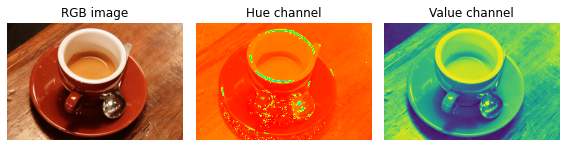

In [2]:
rgb_img = data.coffee()
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

На основании цветового пространства HSV можно проводить базовую сегментацию. Установим порог на канале Hue, чтобы отделить чашку от фона.

In [3]:
hue_threshold = 0.04
binary_img = hue_img > hue_threshold

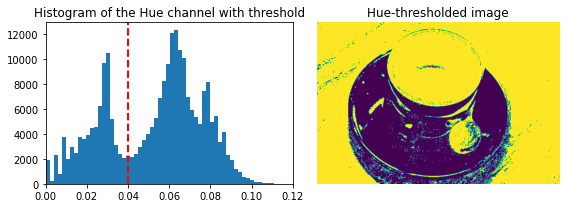

In [4]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(hue_img.ravel(), 512)
ax0.set_title("Histogram of the Hue channel with threshold")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(0, 0.12)
ax1.imshow(binary_img)
ax1.set_title("Hue-thresholded image")
ax1.axis('off')

fig.tight_layout()

Выполним дополнительную пороговую обработку для канала Value, чтобы частично удалить тень чашки.

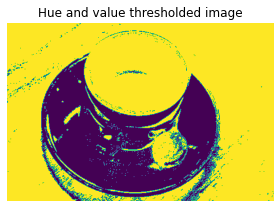

In [5]:
fig, ax0 = plt.subplots(figsize=(4, 3))

value_threshold = 0.10
binary_img = (hue_img > hue_threshold) | (value_img < value_threshold)

ax0.imshow(binary_img)
ax0.set_title("Hue and value thresholded image")
ax0.axis('off')

fig.tight_layout()
plt.show()

В OpenCV доступно более 150 методов преобразования цветового пространства. Но мы рассмотрим только два, которые наиболее широко используются: BGR ↔ Gray и BGR ↔ HSV.

Для преобразования цвета мы используем функцию cv.cvtColor (input_image, flag), где flag определяет тип преобразования.

Для преобразования BGR → Gray мы используем флаг cv.COLOR_BGR2GRAY. Аналогично для BGR → HSV мы используем флаг cv.COLOR_BGR2HSV. 

Рассмотрим существующие флаги:

In [6]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print(flags)

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_BAYER_GR2GRAY', 'COLOR_BAYER_GR2RGB', 'COLOR_BAYER_GR2RGBA', 'COLOR_BAYER_GR2RGB_EA', 'COLOR_BAYER_GR2RGB_VNG', 'COLOR_BAYER_RG2BGR', 'COLOR_BAYER_RG2BGRA', 'COLOR_BAYER_RG2BGR_EA', 'COLOR_BAYER_RG2BGR_VNG', 'COLOR_BAYER_RG2GRAY', 'COLOR_BAYER_RG2RGB', 'COLOR_BAYER_RG2RGBA', 'COLOR_BAYER_RG2RGB_EA', 'COLOR_BAYER_RG2RGB_VNG', 'COLOR_BGR2BGR555', 'COLOR_BGR2BGR565', 'COLOR_BGR2BGRA', 'COLOR_BGR2GRAY', 'COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_

Следует отметить, для HSV диапазон оттенков составляет [0,179], диапазон насыщенности - [0,255], а диапазон значений - [0,255]. В разных программах используются разные масштабы. Поэтому, если вы сравниваете значения OpenCV с ними, необходимо нормализовать эти диапазоны.

## 1.2. Отслеживание объекта на основе модели HSV
Теперь, когда мы знаем, как преобразовать изображение BGR в HSV, мы можем использовать его для извлечения объекта из сцены. В HSV легче представить цвет, чем в цветовом пространстве BGR. Далее мы попытаемся извлечь объект синего цвета:
- регистрируем каждый кадр видео
- преобразовываем из BGR в HSV
- устанавливаем порог изображения HSV для диапазона синего цвета
- извлекаем только синий объект

In [3]:
cap = cv2.VideoCapture(0)

# define range of blue color in HSV
lower_color = np.array([100,50,50])
upper_color = np.array([130,255,255])

while(True):
    
    # Take each frame
    _, frame = cap.read()
    
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_color, upper_color)
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
    cv2.imshow('frame',frame)
    cv2.imshow('mask',mask)
    cv2.imshow('res',res)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
cv2.destroyAllWindows()
cap.release()

## 1.3. Бинаризация изображений
Установление пороговых значений используется для создания двоичного изображения из изображения в оттенках серого.

Рассмотрим применение алгоритмов пороговой обработки. Один из самых универсальных алгоритмов -  Метод Оцу - вычисляет «оптимальный» порог (отмечен красной линией на гистограмме ниже) путем максимизации дисперсии между двумя классами пикселей, которые разделены пороговым значением. Равным образом этот порог минимизирует внутриклассовую дисперсию.

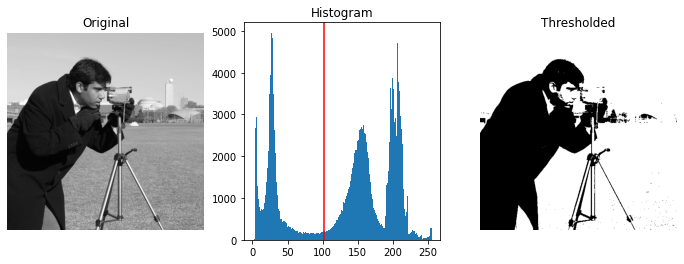

In [8]:
image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

На практике для выбора конкретного алгоритма бинаризации полезно сравнить несколько подходов. Scikit-image включает функцию для оценки алгоритмов пороговой обработки, предоставляемых библиотекой.

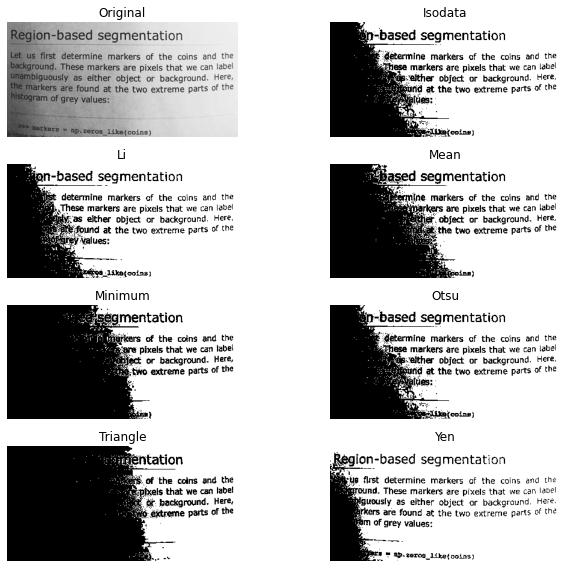

In [9]:
img = data.page()
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

## 2. Морфологическая обработка
Морфологические преобразования - это группа простых операций, основанных на форме объектов на изображении. Обычно операция выполняется для двоичных изображений, иногда для серошкальных. Для реализации нужно два входа, один - это наше исходное изображение, второй - структурный элемент или ядро, которое определяет характер операции.

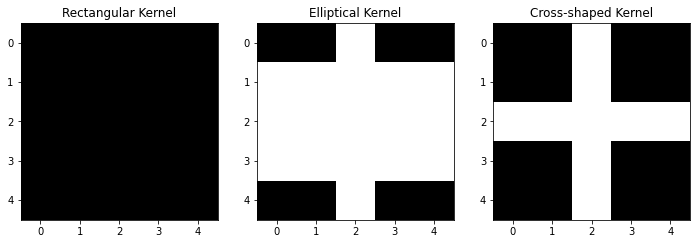

In [10]:
# Rectangular Kernel
kern_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
# Elliptical Kernel
kern_ellip = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# Cross-shaped Kernel
kern_cross = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1, sharex=ax[0], sharey=ax[0])
ax[1] = plt.subplot(1, 3, 2, sharex=ax[0], sharey=ax[0])
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(kern_rect, cmap=plt.cm.gray)
ax[0].set_title('Rectangular Kernel')

ax[1].imshow(kern_ellip, cmap=plt.cm.gray)
ax[1].set_title('Elliptical Kernel')

ax[2].imshow(kern_cross, cmap=plt.cm.gray)
ax[2].set_title('Cross-shaped Kernel')

plt.show()

Считаем изображение и определим функцию для демонстрации эффектов морфологической обработки

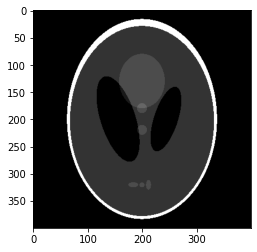

In [11]:
orig_phantom = img_as_ubyte(data.shepp_logan_phantom())
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

In [12]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

## 2.1. Эрозия
Морфологическая эрозия устанавливает пиксель в (i, j) на минимум по всем пикселям в окрестности с центром в (i, j). Элемент структурирования, selem, переданный в erosion, представляет собой логический массив, который описывает эту окрестность. Ниже мы используем диск для создания кругового структурирующего элемента, который используется в большинстве следующих примеров.

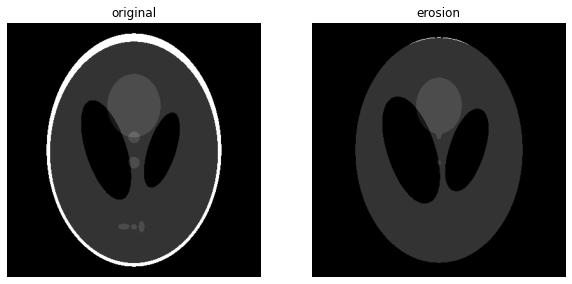

In [13]:
selem = disk(6)
eroded = erosion(orig_phantom, selem)
plot_comparison(orig_phantom, eroded, 'erosion')

## 2.2. Дилатация
Морфологическая дилатация устанавливает пиксель в (i, j) на максимум по всем пикселям в окрестности с центром в (i, j). Дилатация увеличивает яркие области и уменьшает темные области

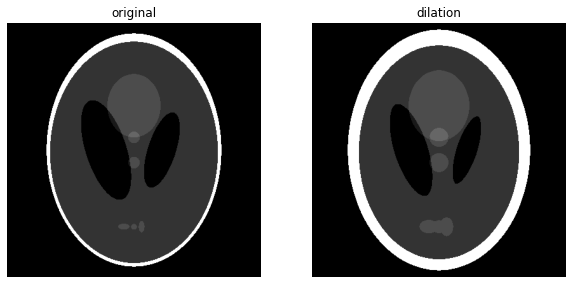

In [14]:
dilated = dilation(orig_phantom, selem)
plot_comparison(orig_phantom, dilated, 'dilation')

## 2.3. Размыкание
Морфологическое размыкание на изображении определяется как эрозия с последующим расширением. Размыкание может удалить небольшие яркие пятна и соединить небольшие темные разрывы.

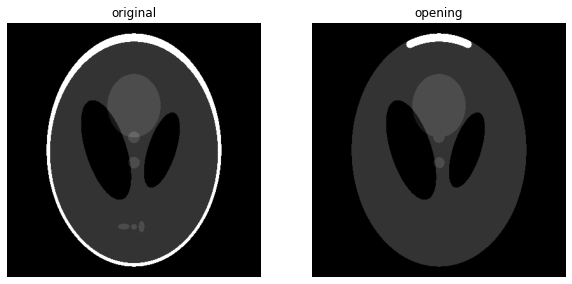

In [15]:
opened = opening(orig_phantom, selem)
plot_comparison(orig_phantom, opened, 'opening')

Пример применения размыкания с помощью OpenCV

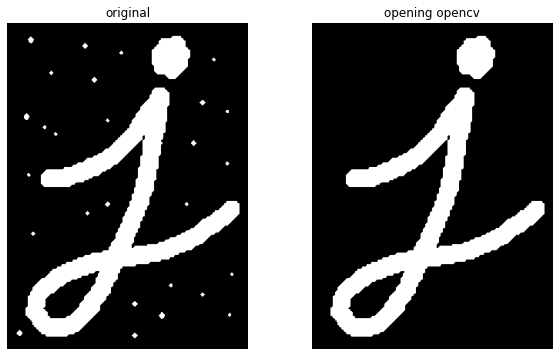

In [16]:
im_j = cv2.imread('j_opening.png',0)
_, im_j = cv2.threshold(im_j,127,255,cv2.THRESH_BINARY)
kernel = np.ones((7,7),np.uint8)

opening_j = cv2.morphologyEx(im_j, cv2.MORPH_OPEN, kernel)
plot_comparison(im_j, opening_j, 'opening opencv')

## 2.4. Замыкание
Морфологическое замыкание изображения определяется как дилатация, за которой следует эрозия. Замыкание позволяет удалить небольшие темные пятна и соединить небольшие светлые разрывы.

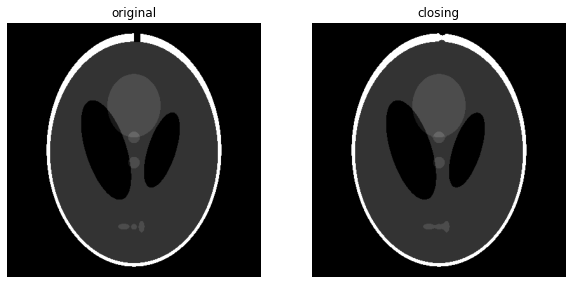

In [17]:
phantom = orig_phantom.copy()
phantom[10:30, 200:210] = 0

closed = closing(phantom, selem)
plot_comparison(phantom, closed, 'closing')

Пример применения OpenCV

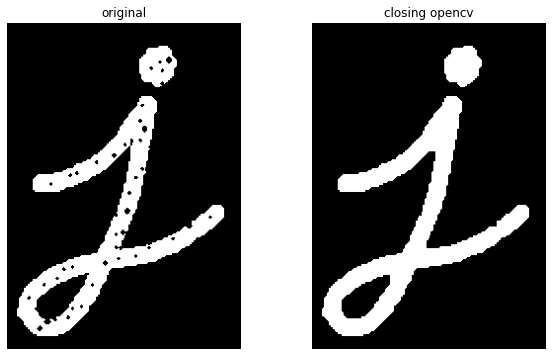

In [18]:
im_j = cv2.imread('j_closing.png',0)
_, im_j = cv2.threshold(im_j,127,255,cv2.THRESH_BINARY)
kernel = np.ones((7,7),np.uint8)

closing_j = cv2.morphologyEx(im_j, cv2.MORPH_CLOSE, kernel)
plot_comparison(im_j, closing_j, 'closing opencv')

## 2.5. Морфологический градиент
Морфологический градиент вычисляется как разница между дилатацией и эрозией изображения. 

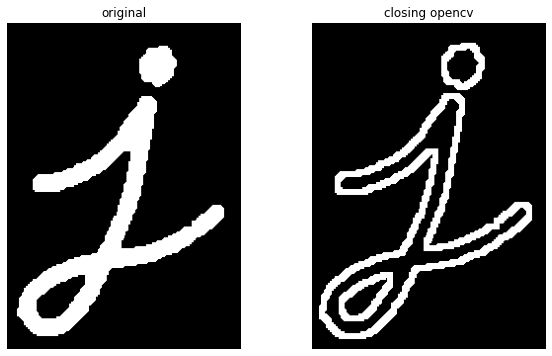

In [19]:
gradient = cv2.morphologyEx(closing_j, cv2.MORPH_GRADIENT, kernel)

plot_comparison(closing_j, gradient, 'closing opencv')

## 2.6. Tophat-фильтрация
White_tophat преобразования изображения определяется как изображение за вычетом его морфологического размыкания. Эта операция возвращает яркие точки изображения, которые меньше структурного элемента.

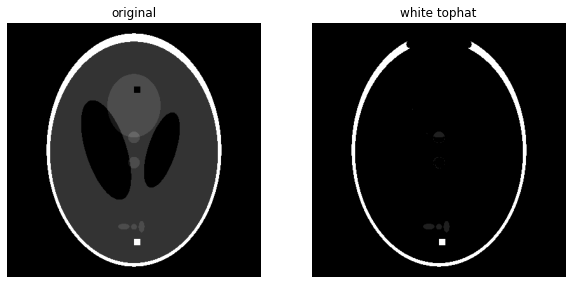

In [20]:
phantom = orig_phantom.copy()
phantom[340:350, 200:210] = 255
phantom[100:110, 200:210] = 0

w_tophat = white_tophat(phantom, selem)
plot_comparison(phantom, w_tophat, 'white tophat')

С помощью tophat преобразования можно выполнять фильтрацию. Например, можно выполнять удаление мелких объектов на изображениях в градациях серого. В данном случае воспользуемся преобразование white tophat, которое определяется как разница между входным изображением и его размыканием.

In [21]:
image = color.rgb2gray(data.hubble_deep_field())[:500, :500]

selem_th =  disk(2)
res = white_tophat(image, selem_th)

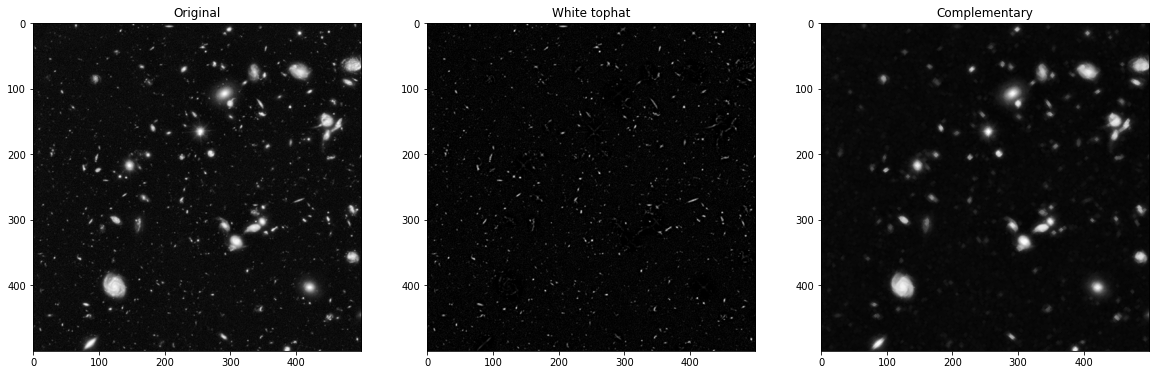

In [22]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
ax[0].set_title('Original')
ax[0].imshow(image, cmap='gray')
ax[1].set_title('White tophat')
ax[1].imshow(res, cmap='gray')
ax[2].set_title('Complementary')
ax[2].imshow(image - res, cmap='gray')

plt.show()

Применение Black Tophat. Black_tophat изображения определяется как его морфологическое размыкание за вычетом исходного изображения. Эта операция возвращает темные пятна изображения, которые меньше структурного элемента.

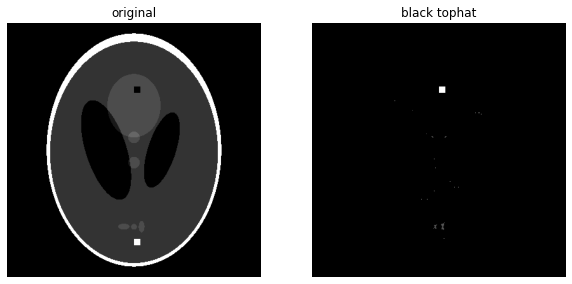

In [23]:
b_tophat = black_tophat(phantom, selem)
plot_comparison(phantom, b_tophat, 'black tophat')

## 2.7. Формирование остова
Формирование остова используется для уменьшения каждого связного компонента в двоичном изображении до скелета объекта шириной в один пиксель. Важно отметить, что эта операция выполняется только для двоичных изображений.  

Формирование скелета объекта может быть полезно для извлечения признаков и / или представления топологии объекта.

Скелетонизация работает на основе последовательных проходов изображения. На каждом проходе граничные пиксели идентифицируются и удаляются при условии, что они не нарушают связность соответствующего объекта.

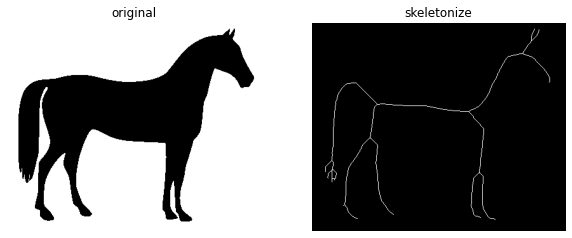

In [24]:
horse = data.horse()

sk = skeletonize(horse == 0)
plot_comparison(horse, sk, 'skeletonize')

__Подходы к построению остова__
Метод skeletonize работает, выполняя последовательные проходы изображения, удаляя пиксели на границах объекта. Это продолжается до тех пор, пока больше не удастся удалить пиксели. Изображение коррелируется с маской, которая присваивает каждому пикселю номер в диапазоне [0… 255], соответствующий каждому возможному шаблону из его 8 соседних пикселей. Затем используется таблица поиска для присвоения пикселям значения 0, 1, 2 или 3, которые выборочно удаляются во время итераций.

Существует метод построения остова по методу Lee (skeletonize (..., method = 'lee')), который использует структуру данных октодерева для исследования окрестности пикселя размером 3x3х3. Алгоритм выполняется путем итеративного прохождения по изображению и удаления пикселей на каждой итерации, пока изображение не перестанет изменяться. Каждая итерация состоит из двух шагов: во-первых, составляется список кандидатов на удаление; затем пиксели из этого списка последовательно перепроверяются, чтобы лучше сохранить связность изображения.

Обратите внимание, что метод Ли разработан для использования с трехмерными изображениями и выбирается для них автоматически. В иллюстративных целях мы применяем этот алгоритм к двухмерному изображению.

In [25]:
blobs = data.binary_blobs(200, blob_size_fraction=.2,
                          volume_fraction=.35, seed=1)

skeleton = skeletonize(blobs)
skeleton_lee = skeletonize(blobs, method='lee')

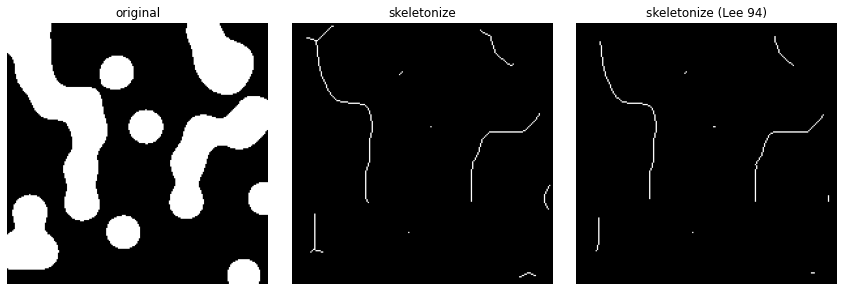

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeletonize')
ax[1].axis('off')

ax[2].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[2].set_title('skeletonize (Lee 94)')
ax[2].axis('off')

fig.tight_layout()
plt.show()

Построение средней оси объекта - это получение совокупности всех точек, имеющих более одной ближайшей точки на границе объекта. Среднюю ось объекта часто называют топологическим каркасом, потому что это каркас объекта шириной 1 пиксель с той же связностью, что и исходный объект.

Здесь мы используем преобразование средней оси для вычисления ширины объектов переднего плана. Поскольку функция medial_axis возвращает преобразование расстояния в дополнение к средней оси (с аргументом return_distance = True), с помощью этой функции можно вычислить расстояние до фона для всех точек медиальной оси. Это дает оценку локальной ширины объектов.

Для объекта с меньшим количеством ветвей предпочтительнее использовать построение остова с помощью метода skeletonize.

In [27]:
# Generate the data
blobs = data.binary_blobs(200, blob_size_fraction=.2,
                          volume_fraction=.35, seed=1)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(blobs, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(blobs)
skeleton_lee = skeletonize(blobs, method='lee')

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

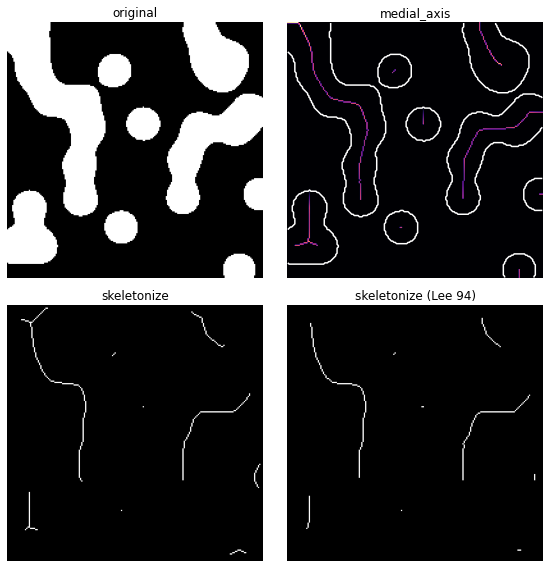

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].contour(blobs, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[3].set_title("skeletonize (Lee 94)")
ax[3].axis('off')

fig.tight_layout()
plt.show()

## 2.8. Морфологическое утончение
Морфологическое утончение работает по тому же принципу, что и скелетонизация: выполняется удаление пикселей с границ на каждой итерации, пока ни один из них не может быть удален без изменения связности. Различные правила удаления могут ускорить утончение и привести к получению разных окончательных остовов.

Функция морфологического утончения принимает необязательный аргумент max_iter, чтобы ограничить количество итераций прореживания и, таким образом, создать относительно более толстый каркас.

In [29]:
image = invert(data.horse())
skeleton = skeletonize(image)
thinned = thin(image)
thinned_partial = thin(image, max_iter=25)

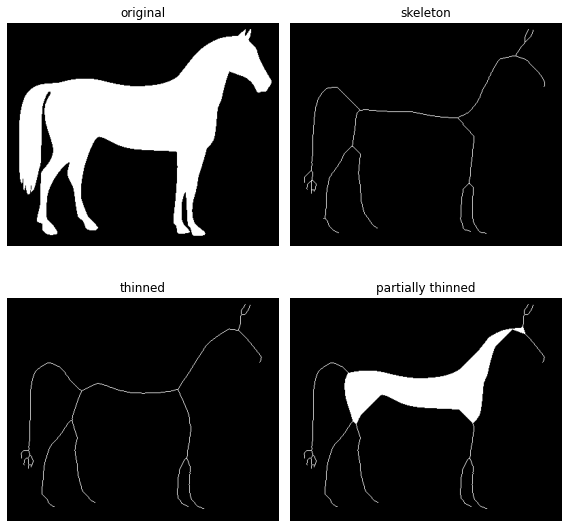

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeleton')
ax[1].axis('off')

ax[2].imshow(thinned, cmap=plt.cm.gray)
ax[2].set_title('thinned')
ax[2].axis('off')

ax[3].imshow(thinned_partial, cmap=plt.cm.gray)
ax[3].set_title('partially thinned')
ax[3].axis('off')

fig.tight_layout()
plt.show()

## 2.9. Формирование выпуклой оболочки
Выпуклая оболочка изображения - это набор пикселей, включенных в наименьший выпуклый многоугольник, который окружает все белые пиксели входного изображения. Обратите внимание, что эта операция также выполняется с бинарными изображениями.

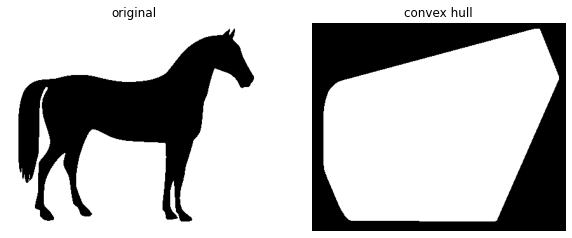

In [31]:
horse = data.horse()
hull1 = convex_hull_image(horse == 0)
plot_comparison(horse, hull1, 'convex hull')

Как показано на рисунке, convx_hull_image дает самый маленький многоугольник, который полностью покрывает белый цвет или значение True на изображении.

Если мы добавим к изображению небольшую зернистость, мы увидим, как выпуклая оболочка адаптируется, чтобы охватить это зерно

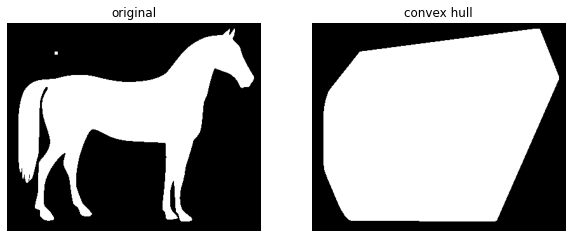

In [32]:
horse_mask = horse == 0
horse_mask[45:50, 75:80] = 1

hull2 = convex_hull_image(horse_mask)
plot_comparison(horse_mask, hull2, 'convex hull')

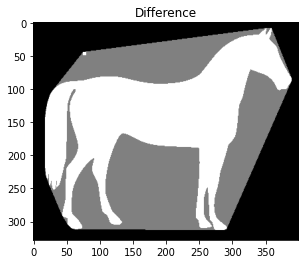

In [33]:
hull_diff = img_as_float(hull2.copy())
hull_diff[horse_mask] = 2

fig, ax = plt.subplots()
ax.imshow(hull_diff, cmap=plt.cm.gray)
ax.set_title('Difference')
plt.show()

## 3. Основы сегментации
## 3.1. Детектор границ Canny
Фильтр Кэнни - это многоступенчатый алгоритм детектирования границ. Данный фильтр основан на производной Гаусса для оценки интенсивности градиентов. Гауссовый фильтр уменьшает эффект шума, присутствующего в изображении. Затем потенциальные границы прореживаются до примитивов толщиной в 1 пиксель путем удаления не максимальных пикселей градиента. Наконец, краевые пиксели сохраняются или удаляются с использованием порогового значения гистерезиса.

Canny имеет три настраиваемых параметра: ширину гауссиана (чем шумнее изображение, тем больше ширина), нижний и верхний пороги для порогового значения гистерезиса.

1. Поскольку обнаружение краев чувствительно к шуму в изображении, первым этапом является удаление шума в изображении с помощью гауссовского фильтра 5x5.  
  
2. Нахождение градиента интенсивности изображения. Сглаженное изображение фильтруется с помощью ядра Собеля как в горизонтальном, так и в вертикальном направлении, чтобы получить первую производную в горизонтальном направлении (Gx) и вертикальном направлении (Gy). Из этих двух изображений мы можем найти градиент и направление границ для каждого пикселя:
$$ Edge\_Gradient \; (G) = \sqrt{G_x^2 + G_y^2} \\ Angle \; (\theta) = \tan^{-1} \bigg(\frac{G_y}{G_x}\bigg)$$
3. Подавление не максимальных значений. После получения величины и направления градиента выполняется полное сканирование изображения для удаления любых нежелательных пикселей, которые могут не принадлежать границам. Для этого проверяется пиксель: является ли он локальным максимумом в окрестности в направлении градиента.
<img src="https://docs.opencv.org/master/nms.jpg" width="300" height="300">  
Точка А находится на краю (в вертикальном направлении). Направление градиента перпендикулярно краю. Точки B и C находятся в направлениях градиента. Таким образом, точка A сравнивается с точками B и C, чтобы оценить, образует ли она локальный максимум. В противном случае, значение подавляется (обнуляется). В результате, мы получаем двоичное изображение с «тонкими границами».
  
4. Оценка порогового значения гистерезиса. На этом этапе решается, какие из границ действительно являются границами, а какие нет. Для этого нам нужны два пороговых значения: minVal и maxVal. Любые края с градиентом интенсивности больше maxVal обязательно будут краями, а те, что ниже minVal, обязательно не будут краями. Те границы, что находятся между этими двумя порогами, классифицируются как границы в зависимости от их связности. Если они соединены с пикселями с четкими границами, они считаются частью границ. В противном случае они также отбразываются.
<img src="https://docs.opencv.org/master/hysteresis.jpg" width="400" height="400"> 
В указанном примере граница A выше maxVal, поэтому считается "надежной границей". Хотя край C ниже maxVal, он соединен с ребром A, поэтому он также считается допустимым, и мы получаем полную кривую. Но ребро B, хотя оно выше minVal и находится в той же области, что и ребро C, не связано с каким-либо "точным краем", поэтому оно отбрасывается. На этом этапе также удаляются мелкие шумы.  

__Пример использования детектора границ Canny в библиотеке OpenCV__

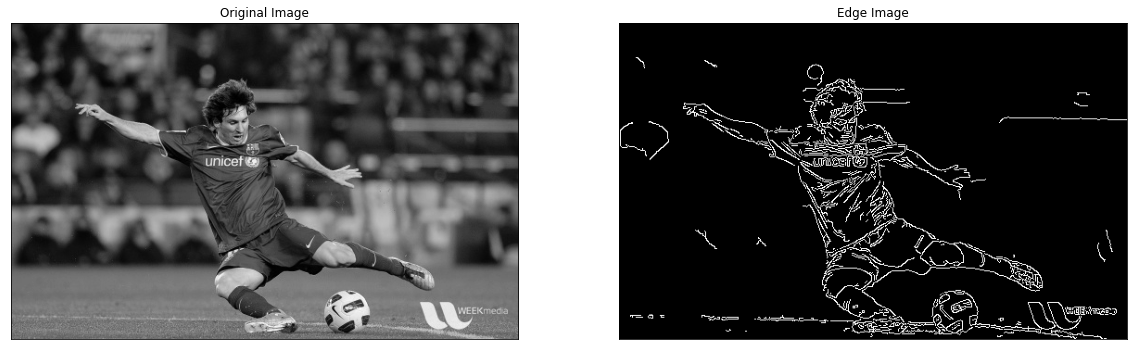

In [34]:
img = cv2.imread('messi.jpg',0)
edges = cv2.Canny(img,100,200)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

__Пример использования детектора границ Canny в библиотеке Scikit-image__  
Зададим размытое изображение с шумом

In [35]:
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

Применим детектор границ Canny с различными значениями sigma промежуточного Гауссова фильтра

In [36]:
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

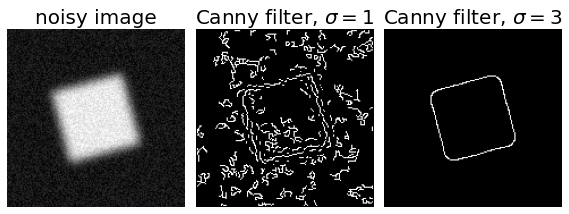

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

## 3.2. Круговое преобразование Хафа
Преобразование Хафа в его простейшей форме - это метод обнаружения прямых линий, но его также можно использовать для обнаружения кругов или эллипсов. Алгоритм предполагает, что границы на изображении уже обнаружены, а шумы или отсутствующие точки/разрыва устранены.

### Алгоритм поиска круговых объектов
Допустим на белом фоне располагается черный круг. Для начала мы задаем диапазон радиусов, по которым могут быть построены потенциальный круг. Этот круг наносится на каждый черный пиксель исходного изображения, и координаты этого круга учитываются в аккумуляторе. Далее подбирается положение центра круга, которое получает наивысший балл в аккумуляторе.  
Обратите внимание, что размер аккумуляторного объекта больше, чем у исходного изображения, чтобы определять центры кругов за пределами кадра.

### Пример обнаружения кругов с помощью Scikit-image
В следующем примере преобразование Хафа используется для определения положения монет. В начале мы предполагаем ряд возможных радиусов. Для каждого радиуса извлекаются два круга. Далее оставляем пять наиболее выдающихся кандидатов.

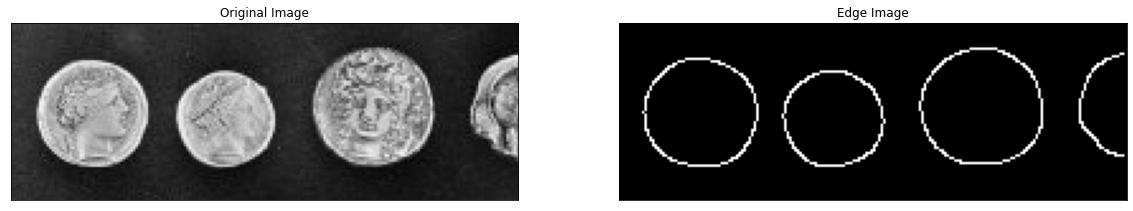

In [38]:
# Load picture and detect edges
image = img_as_ubyte(data.coins()[160:230, 70:270])
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [39]:
# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii)

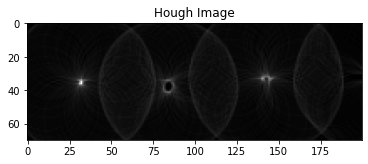

In [40]:
plt.imshow(hough_res[1],cmap = 'gray')
plt.title('Hough Image')
plt.show()

In [41]:
# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

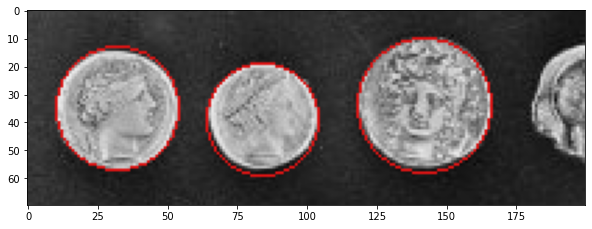

In [42]:
# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

Получены координаты центров и радиусов объектов на изображении

In [43]:
cx, cy, radii

(array([ 32, 142,  84]), array([35, 34, 39]), array([22, 24, 20]))

### Алгоритм поиска эллипсов
Алгоритм берет две разные точки, принадлежащие эллипсу. Предполагается, что это главная ось. Цикл по всем другим точкам определяет, насколько эллипс включает их. Хорошее совпадение соответствует высоким значениям аккумулятора. По пиковым значениям аккумулятора выбирается значение, определяющее локализацию эллипса.

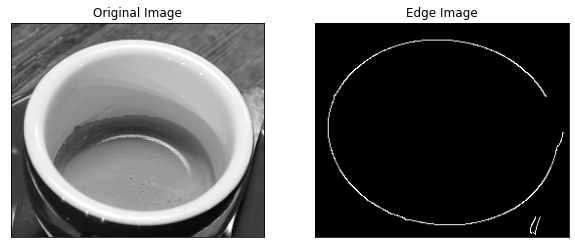

In [44]:
# Load picture, convert to grayscale and detect edges
image_rgb = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplot(121),plt.imshow(image_gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [45]:
# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

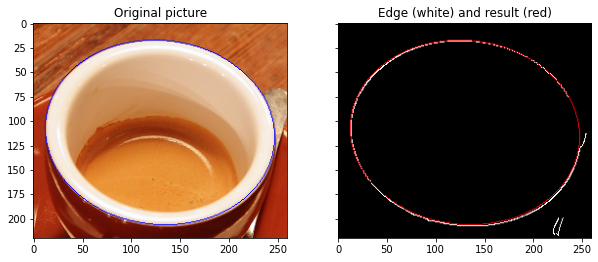

In [46]:
# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

### Применение библиотеки OpenCV

In [47]:
img = img_as_ubyte(data.coins()[160:230, 70:270])
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,30,
                            param1=65,param2=40,minRadius=10,maxRadius=35)
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

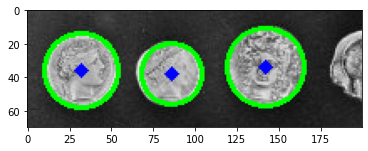

In [48]:
plt.imshow(cimg)

## 3.3. Сегментация на основе водораздела
Сегментация на основе водораздела - это классический алгоритм, используемый для сегментации, то есть для разделения различных объектов на изображении.

Любое изображение в оттенках серого можно рассматривать как топографическую поверхность, где высокая интенсивность обозначает пики и холмы, а низкая интенсивность обозначает впадины.

Начиная с определяемых пользователем маркеров, алгоритм водораздела обрабатывает значения пикселей как местную топографию (высоту). Алгоритм затопляет бассейны от маркеров до тех пор, пока бассейны, относящиеся к разным маркерам (уровням интенсивности), не встретятся на линиях водоразделов. Во многих случаях маркеры выбираются в качестве локальных минимумов изображения, из которых затопляются бассейны.

### Процесс сегментации, реализуемой в библиотеке Scikit-image. 
В приведенном ниже примере необходимо разделить два перекрывающихся круга. Для этого вычисляется изображение, представляющее собой расстояние до фона. Максимумы этого расстояния выбраны в качестве маркеров, и затопление бассейнов от таких маркеров разделяет два круга вдоль линии водораздела. Подобный подход позволяет проводить сегментацию перекрывающихся объектов.

Сгенерируем два перекрывающихся круга.

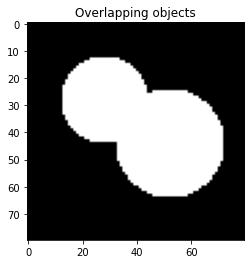

In [49]:
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

plt.imshow(image, cmap=plt.cm.gray)
plt.title('Overlapping objects')
plt.show()

Определим центры объектов

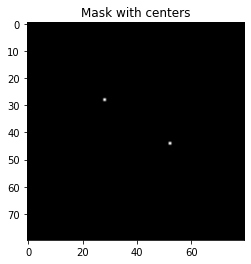

In [50]:
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True

plt.imshow(mask, cmap=plt.cm.gray)
plt.title('Mask with centers')
plt.show()

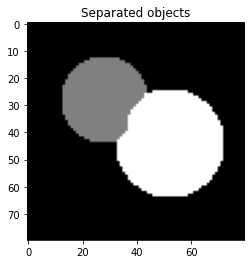

In [51]:
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

plt.imshow(labels, cmap=plt.cm.gray)
plt.title('Separated objects')
plt.show()

### Процесс сегментации, реализуемый в библиотеке OpenCV
В OpenCV алгоритм водораздела также реализован на основе маркеров. Данный подход представляет собой интерактивную сегментацию изображений. В рамках такого подхода:
- мы можем указать области, которые, как мы уверены, являются передним планом или объектом,
- далее можем отметить область фона/не искомого объекта 
- а область, в которой заранее неизвестно наличие объекта выбирается в качестве маркера
- применим алгоритм водораздела

Ниже мы увидим пример того, как использовать Distance Transform вместе с водоразделом для сегментации взаимно соприкасающихся объектов.

Рассмотрим изображение монет, которые соприкасаются друг с другом.

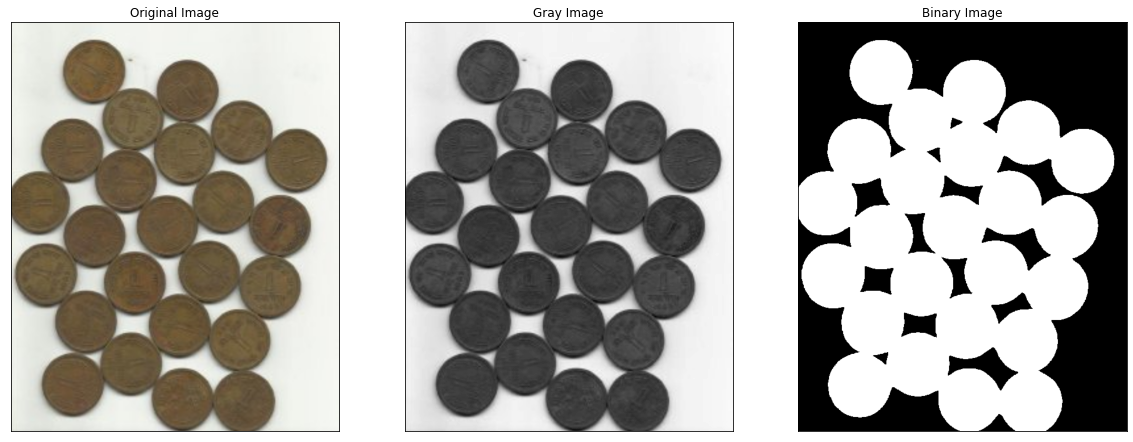

In [52]:
img = cv2.imread('coins.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
plt.subplot(131),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(gray,cmap = 'gray')
plt.title('Gray Image'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(thresh,cmap = 'gray')
plt.title('Binary Image'), plt.xticks([]), plt.yticks([])
plt.show()

Теперь нам нужно удалить шумы на изображении. Для этого мы можем использовать морфологическое размыкание. Чтобы удалить небольшие отверстия в объекте, мы можем использовать морфологическое Замыкание. После выполнения данных операций мы точно знаем, что область рядом с центром объекта является передним планом, а область далеко от объекта - фоном. Единственная область, в которой мы не уверены, - это граничная область монет.

Итак, нам нужно извлечь область, в которой мы уверены, что это монеты. Эрозия удаляет граничные пиксели. Это сработало бы, если бы предметы не касались друг друга. Но поскольку они касаются друг друга, еще одним хорошим вариантом было бы найти преобразование расстояния и применить правильный порог. Затем нужно найти область, в которой точно не располагаются монеты. Для этого применяме дилатацию. Дилатация увеличивает границу объекта до фона. Таким образом, мы можем убедиться, что любая область фона в результате действительно является фоном.

In [53]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

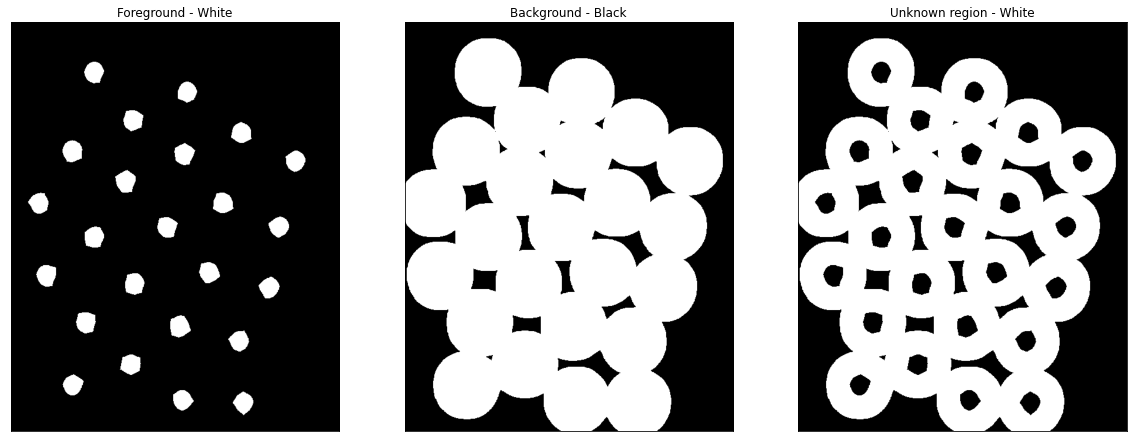

In [54]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
plt.subplot(131),plt.imshow(cv2.cvtColor(sure_fg, cv2.COLOR_BGR2RGB))
plt.title('Foreground - White'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(sure_bg,cmap = 'gray')
plt.title('Background - Black'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(unknown,cmap = 'gray')
plt.title('Unknown region - White'), plt.xticks([]), plt.yticks([])
plt.show()

Теперь мы точно знаем, в каком регионе находятся монеты, где располагается фон. 
Далее мы создаем маркер (это массив того же размера, что и исходное изображение, но с типом данных int32) и маркируем области внутри него. Области, которые мы знаем наверняка (будь то передний план или фон), помечены любыми положительными целыми числами (разными целыми числами), а область, которую мы точно не знаем, просто оставляется равной нулю. Для этого мы используем cv.connectedComponents (). Он помечает фон изображения цифрой 0, затем другие объекты помечаются целыми числами, начиная с 1.

In [55]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

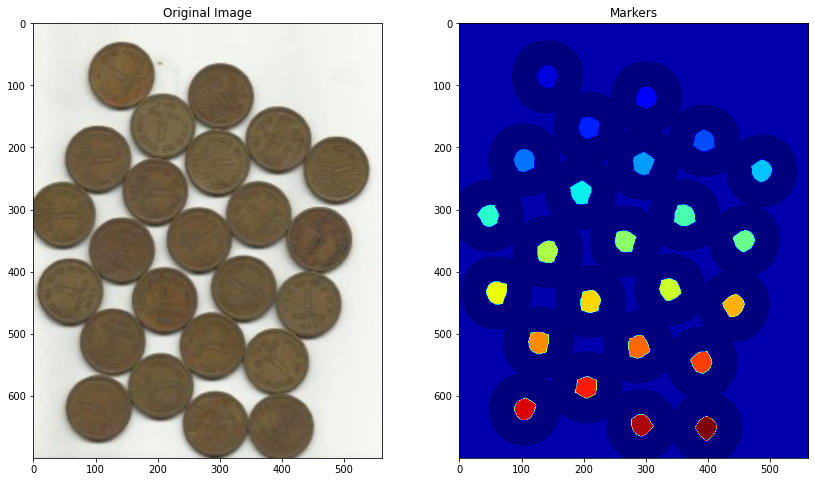

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(122),plt.imshow(markers, cmap="jet")
plt.title('Markers')

plt.show()

Применим алгоритм сегментации на основе водораздела

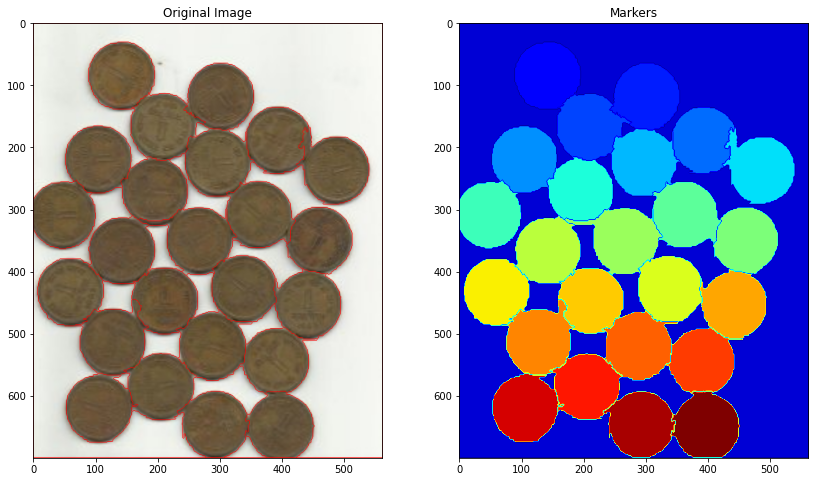

In [57]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [0,0,255]

fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(122),plt.imshow(markers, cmap="jet")
plt.title('Markers')

plt.show()

## 3.4. Общий пайплан сегментации объектов
Далее представлен полный пайплайн сегментации изображений с построением меток объектов. Применяются следующие шаги:
- Установление пороговых значений бинаризации с помощью автоматического метода Оцу
- Заполнение маленьких разрывов с помощью морвологического замыкания
- Удаление артефактов соприкосновения границ объектов
- Измерение областей изображения для фильтрации мелких посторонних объектов

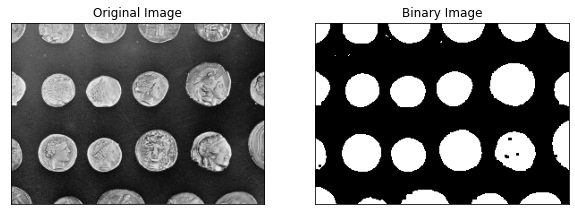

In [58]:
image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(bw,cmap = 'gray')
plt.title('Binary Image'), plt.xticks([]), plt.yticks([])
plt.show()

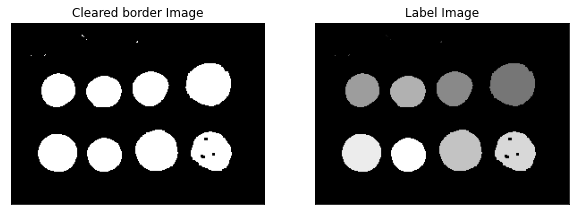

In [59]:
# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
                                
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplot(121),plt.imshow(cleared,cmap = 'gray')
plt.title('Cleared border Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(label_image,cmap = 'gray')
plt.title('Label Image'), plt.xticks([]), plt.yticks([])
plt.show()

Object 5: (46, 195, 94, 246)
Object 6: (55, 136, 94, 177)
Object 7: (57, 34, 95, 72)
Object 8: (60, 84, 95, 124)
Object 9: (120, 139, 166, 187)
Object 10: (122, 201, 166, 247)
Object 11: (125, 30, 167, 74)
Object 12: (129, 85, 167, 124)


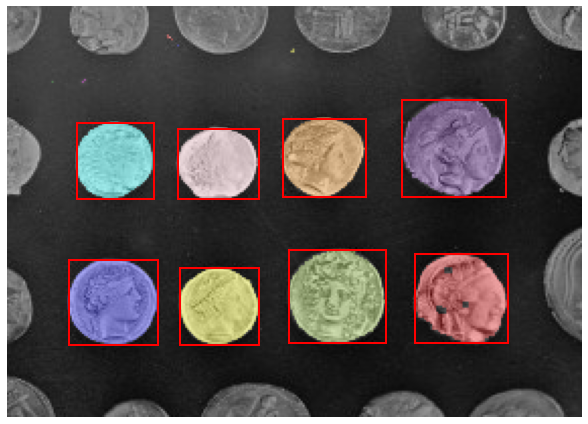

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for i, region in enumerate(regionprops(label_image)):
    
    # take regions with large enough areas
    if region.area >= 100:
        print(f"Object {i}: {region.bbox}")
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

## 4. Практический пример отслеживания объекта
Воспользуемся:
- переходом в цветовую модель HSV
- созданием маски для объекта с заданным цветом
- морфологической обработкой полученной маски
- нахождением контура объекта
- вычислением наименьшей окружности, охватвающей объект
- сохранением буфера последних точек локализации объекта

In [2]:
# Зададим параметры отслеживаемого объекта в пространстве HSV
colorLower = (24, 100, 100)
colorUpper = (44, 255, 255)
pts = deque(maxlen=64)
 
# Создадим объект камеры
camera = cv2.VideoCapture(0)
 
# Работа с камерой в цикле
while True:
    # Прочитаем текущий кадр
    (grabbed, frame) = camera.read()
  
    frame = imutils.resize(frame, width=600)
    frame = imutils.rotate(frame, angle=180)
    
    # Выполним переход в цветовую модель HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
 
    # Создадим маску для объекта с заданным цветом
    mask = cv2.inRange(hsv, colorLower, colorUpper)
    
    # Морфологическая обработка маски
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    # Поиск контуров и центра объекта
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    center = None
 
    # Если был найден контур
    if len(cnts) > 0:
        # найти наибольший контур по маске, затем использовать его
        # для вычисления наименьшей окружности, охватывающей объект
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
 
        if radius > 10:
            # нарисовать окружность локализации объекта
            cv2.circle(frame, (int(x), int(y)), int(radius),
                (0, 255, 255), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
 
    # обновить список точек
    pts.appendleft(center)
    
    # Цикл по всем текущем (64) точкам локализации
    for i in range(1, len(pts)):
        if pts[i - 1] is None or pts[i] is None:
            continue
 
        # Нарисовать след объекта
        thickness = int(np.sqrt(64 / float(i + 1)) * 2.5)
        cv2.line(frame, pts[i - 1], pts[i], (0, 0, 255), thickness)
 
    # Отобразить картинку на экране
    frame = imutils.rotate(frame, angle=180)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
 
    # выйти из цикла обработки изображения
    if key == ord("q"):
        break

# Освободить ресурс камеры и закрыть всплывающее окно
camera.release()
cv2.destroyAllWindows()

## Задание
1. Считать изображение цитологического мазка крови (blood.jpg).
2. Привести к полутоновому формату и провести бинаризацию, предварительно визуально оценив подходящий метод.
3. Выполнить инверсию бинарного изображения
4. Применить морфологическую обработку для устранения посторонних объектов, заполнения разрывов в контурах
5. Выполнить выделение границ с помощью детектора Canny
6. Выполнить сегментацию клеток крови (выбрать подходящий алгоритм сегментации)
7. Визуализировать метки сегментации на исходном изображении